# Setup

In [1]:
from IPython.display import clear_output as cls

In [2]:
# data no split
# https://drive.google.com/file/d/1ey1O_1cZEnqP8s4mHjCvT8vpfAOlvP9L/view?usp=sharing

# data with split - train val test
# https://drive.google.com/file/d/14Rjq65k_qzXDje0atzyDl9WziapGaifp/view?usp=sharing

# data with split and converted - train val test
# https://drive.google.com/file/d/10eYtkh6bTWNwH_--xZtU8IxB5cZPVc3O/view?usp=drive_link

### ABOVE IS UNUSED

# data with split and converted clean - train val test
# https://drive.google.com/file/d/184s1XY7oZ2ukeMUzhMjH-MEXROGuGCk3/view?usp=drive_link

# data with split, converted clean, and augmented
# https://drive.google.com/file/d/1bydjm-fAYVwa-1J7J5riWVEWc2OVM3BZ/view?usp=drive_link

!pip install gdown

!rm -r dataset
# !gdown "https://drive.google.com/uc?id=184s1XY7oZ2ukeMUzhMjH-MEXROGuGCk3" -O dataset.zip
!gdown "https://drive.google.com/uc?id=1bydjm-fAYVwa-1J7J5riWVEWc2OVM3BZ" -O dataset.zip
!unzip dataset.zip -d dataset

cls()

In [3]:
# common
import os
import numpy as np
import tensorflow as tf
import typing
from tensorflow import keras
from typing import Tuple, List
from tqdm import tqdm
from glob import glob
from datetime import datetime

# preprocessing
from tensorflow import image as tfi

# architecture
from tensorflow.keras import Sequential
from tensorflow.keras.applications import Xception, InceptionV3, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

# visualization
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model

# Model Training
from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

# CSV Callback
from tensorflow.keras.callbacks import CSVLogger

cls()

In [4]:
# train_dir = '/kaggle/working/dataset/clean_data_splitted_convert/train/'
# val_dir = '/kaggle/working/dataset/clean_data_splitted_convert/val/'
# test_dir = '/kaggle/working/dataset/clean_data_splitted_convert/test/'

train_dir = '/kaggle/working/dataset/clean_data_splitted_convert_augment/train/'
val_dir = '/kaggle/working/dataset/clean_data_splitted_convert_augment/val/'
test_dir = '/kaggle/working/dataset/clean_data_splitted_convert_augment/test/'

In [5]:
# Constants

IMAGE_SIZE = 300
BATCH_SIZE = 32
EPOCHS = 50
# EPOCHS = 1


LEARNING_RATE = 1e-4
# LEARNING_RATE = 1e-3


LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
METRICS = ['accuracy']
# OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
# OPTIMIZER = SGD(learning_rate=LEARNING_RATE)

# callback
EARLYSTOP_PATIENCE = 5


# Random Seed
random_seed = 42 # set random seed for reproducibility
tf.random.set_seed(random_seed) # set random seed for TensorFlow
np.random.seed(random_seed) # set random seed for NumPy

In [6]:
# Collect the class names
class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)

# Functions

In [7]:
def load_image(image_path: str) -> tf.Tensor:
    
    '''
    The task of the function is to load the image present in the specified given image path. Loading the image the function also performed some 
    preprocessing steps such as resizing and normalization.
    
    Argument:
        image_path(str) : This is a string which represents the location of the image file to be loaded.
        
    Returns:
        image(tf.Tensor) : This is the image which is loaded from the given image part in the form of a tensor.
    '''
    
    # Check if image path exists
    assert os.path.exists(image_path), f'Invalid image path: {image_path}'
    
    # Read the image file
    image = tf.io.read_file(image_path)
    
    # Load the image
    try:
        image = tfi.decode_jpeg(image, channels=3)
    except:
        image = tfi.decode_png(image, channels=3)
    
    # Change the image data type
    image = tfi.convert_image_dtype(image, tf.float32)
    
    # Resize the Image
    image = tfi.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    
    # Rescale pixel values to be in the range [0, 1]
    image = tf.image.per_image_standardization(image)
    
    # Convert image data type to tf.float32
    image = tf.cast(image, tf.float32)
    
    return image

In [8]:
def load_dataset(root_path: str, class_names: list, batch_size: int = 32, buffer_size: int = 1000) -> Tuple[np.ndarray, np.ndarray]:
    '''
    Load and preprocess images from the given root path and return them as numpy arrays.

    Args:
        root_path (str): Path to the root directory where all the subdirectories (class names) are present.
        class_names (list): List of the names of all the subdirectories (class names).
        batch_size (int): Batch size of the final dataset. Defaults to 32.
        buffer_size (int): Buffer size to use when shuffling the data. Defaults to 1000.

    Returns:
        Two numpy arrays, one containing the images and the other containing their respective labels.
    '''

    # Collect total number of data samples
    n_samples = sum([len(os.listdir(os.path.join(root_path, name))) for name in class_names])

    # Create arrays to store images and labels
    images = np.empty(shape=(n_samples, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
    labels = np.empty(shape=(n_samples, 1), dtype=np.int32)

    errors = []
    
    # Loop over all the image file paths, load and store the images with respective labels
    n_image = 0
    for class_name in tqdm(class_names, desc="Loading"):
        class_path = os.path.join(root_path, class_name)
        for file_path in glob(os.path.join(class_path, "*")):
            # Load the image
            try:
                image = load_image(file_path)
                
                # Assign label
                label = class_names.index(class_name)

                # Store the image and the respective label
                images[n_image] = image
                labels[n_image] = label

                # Increment the number of images processed
                n_image += 1
                
            except:
                errors.append(file_path)
            
    # Shuffle the data
    indices = np.random.permutation(n_samples)
    images = images[indices]
    labels = labels[indices]
    
    print('num of errors:', len(errors))

    return images, labels, errors

In [9]:
def load_and_preprocess_image(image, label):
    # Resize the image to the desired size
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    
    # Rescale pixel values to be in the range [0, 1]
    image = tf.image.per_image_standardization(image)
    
#     # Convert image data type to tf.float32
#     image = tf.cast(image, tf.float32)
    
    return image, label

In [10]:
def plot_images(dataset: tf.data.Dataset, n_rows: int = 5, n_cols: int = 4, class_names=class_names, figsize=(20, 20), model=None, check=False):
    """
    Plots a grid of images and their corresponding labels from a tf.data.Dataset object.

    Args:
        dataset (tf.data.Dataset): A TensorFlow dataset object containing the images and labels to plot.
        n_rows (int): Number of rows in the plot grid. Default is 5.
        n_cols (int): Number of columns in the plot grid. Default is 4.
        class_names (list): A list of strings mapping the integer labels to their corresponding class names. Default is None.
        figsize (tuple): A tuple specifying the size of the figure. Default is (20, 20).
        model (tf.keras.Model): A trained TensorFlow model to make predictions on the images. Default is None.
        check (bool): If True and a model is provided, only incorrectly predicted images will be plotted. Default is False.
    """
    
    # Create a figure to display the images
    fig = plt.figure(figsize=figsize)
    
    # Initialize image counter
    image_count = 0
    
    # Loop over all batches in dataset
    for images, labels in dataset:
        
        # Loop over all images in batch
        for i in range(images.shape[0]):
            
            label = int(labels[i].numpy())
            title = "true: "+class_names[label]

            if model:
                pred = model.predict(images[i][np.newaxis])

                if check:
                    if label == np.argmax(pred):
                        continue

                pred_label = f"Pred: {np.argmax(pred)}"
                pred_percentage = f" ({np.max(pred) * 100:.2f}%)"
                if class_names:
                    pred_label += f" ({class_names[np.argmax(pred)]})"
                title += f"\n{pred_label} {pred_percentage}"

            # Create a subplot for each image
            ax = fig.add_subplot(n_rows, n_cols, image_count+1)    

            # Plot the image
            ax.imshow(images[i].numpy().astype("uint8"))

            # Set the title to the corresponding label
            ax.set_title(title)

            # Remove the axis ticks
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Increment image counter
            image_count += 1
            
            # Check if maximum number of images has been reached
            if image_count >= n_rows * n_cols:
                break
        
        # Check if maximum number of images has been reached
        if image_count >= n_rows * n_cols:
            break
    
    # Show the plot
    plt.show()

In [11]:
def timer(start_time: datetime = None) -> "typing.Union[datetime.datetime, str]":
    """
    Measures the time elapsed from a given start time.

    If no start time is provided, returns the current time. If a start time is provided, returns a formatted string
    representing the time elapsed from the start time to the current time.

    Args:
        start_time (datetime.datetime, optional): The start time to measure elapsed time from, or None to get the current time. Defaults to None.

    Returns:
        Union[datetime.datetime, str]: The current time if no start time is provided, or a formatted string representing the elapsed time.
    """
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        return "%i hours %i minutes and %s seconds." % (
            thour,
            tmin,
            round(tsec, 2),
        )

In [12]:
def plot_history(history, test_loss, test_acc, model_name):
    # Collect the history of the training run
    history_plot = pd.DataFrame(history.history)
    
    # Create a figure to display the model's performance
    plt.figure(figsize=(20, 5))

    # Plot the loss curve in the first subplot
    plt.subplot(1, 2, 1)
    plt.title(f"{model_name} - Loss Curve")
    plt.plot(history_plot['loss'], label="Training Loss")
    plt.plot(history_plot['val_loss'], label="Validation Loss")

    # Horizontal line to show the testing performance
    plt.axhline(y=test_loss, label="Test Loss", linestyle='--', color='green')

    # Set the x- and y-labels, and the x- and y-limits
    plt.xlabel("Epochs")
    plt.ylabel("Cross Entropy Loss")
    # plt.ylim([0, 0.4])

    # Show the legend and grid
    plt.legend()
    plt.grid()

    # Plot the accuracy curve in the second subplot
    plt.subplot(1, 2, 2)
    plt.title(f"{model_name} - Accuracy Curve")
    plt.plot(history_plot['accuracy'], label="Training Accuracy")
    plt.plot(history_plot['val_accuracy'], label="Validation Accuracy")

    # Horizontal line to show the testing performance
    plt.axhline(y=test_acc, label="Test Accuracy", linestyle='--', color='green')

    # Set the x- and y-labels, and the x- and y-limits
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    # plt.ylim([0.85, 1])

    # Show the legend and grid
    plt.legend()
    plt.grid()

    # Display the plot
    plt.show()

In [13]:
def plot_confusion_m(y_true, y_pred, class_names=None, figsize=(15,15)):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Data Prep

In [14]:
# Show
print(f"Total number of classes in train: {n_classes}")
print(f"Classes: {class_names}")

Total number of classes in train: 20
Classes: ['ba', 'ca', 'da', 'dha', 'ga', 'ha', 'ja', 'ka', 'la', 'ma', 'na', 'nga', 'nya', 'pa', 'ra', 'sa', 'ta', 'tha', 'wa', 'ya']


In [15]:
# # Load the training dataset
# X_train, y_train, err_train = load_dataset(root_path = train_dir, class_names = class_names)

# # # Load the validation dataset
# X_valid, y_valid, err_val = load_dataset(root_path = val_dir, class_names = class_names)

# # Load the testing dataset
# X_test, y_test, err_test = load_dataset(root_path = test_dir, class_names = class_names)

In [16]:
# print('train err:', err_train)
# print('val err:', err_val)
# print('test err:', err_test)

In [17]:
# del X_train, y_train, X_valid, y_valid, X_test, y_test

## Drop corrupted data

In [18]:
try:
    corrupted = '/kaggle/working/dataset/clean_data_splitted_convert/train/ra/000021.jpg'
    os.remove(corrupted)
except:
    print('Somethings wong!')

Somethings wong!


# Create Dataset

In [19]:
# del train_ds, val_ds, test_ds
# del train_ds_mapped, val_ds_mapped, test_ds_mapped

# Create a dataset from the data directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, 
#                                                                labels='inferred', 
#                                                                label_mode='int',
#                                                                image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                               batch_size=BATCH_SIZE
                                                              )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
#                                                              labels='inferred', 
#                                                              label_mode='int',
#                                                              image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                             batch_size=BATCH_SIZE
                                                              )

test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
#                                                                labels='inferred', 
#                                                                label_mode='int',
#                                                                image_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                               batch_size=BATCH_SIZE
                                                              )

Found 17020 files belonging to 20 classes.
Found 1035 files belonging to 20 classes.
Found 1010 files belonging to 20 classes.


## Preprocessing

In [20]:
train_ds_mapped = train_ds.map(load_and_preprocess_image)
val_ds_mapped = val_ds.map(load_and_preprocess_image)
test_ds_mapped = test_ds.map(load_and_preprocess_image)

train_ds_mapped.prefetch(tf.data.AUTOTUNE)
val_ds_mapped.prefetch(tf.data.AUTOTUNE)
test_ds_mapped.prefetch(tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Data Visualization

In [21]:
# Calculate class distribution
class_dis = [len(os.listdir(train_dir + name)) for name in class_names]
# class_dis = [len(os.listdir(val_dir + name)) for name in class_names]
# class_dis = [len(os.listdir(test_dir + name)) for name in class_names]

# Visualize using interactive pie chart
pie_chart = px.pie(values=class_dis, names=class_names, color=class_names)
pie_chart.update_layout({'title':{'text':"Class Distribution"}})
pie_chart.show()

# Visualize using interactive bar chart
bar_chart = px.bar(y=class_dis, x=class_names, color=class_names)
bar_chart.show()

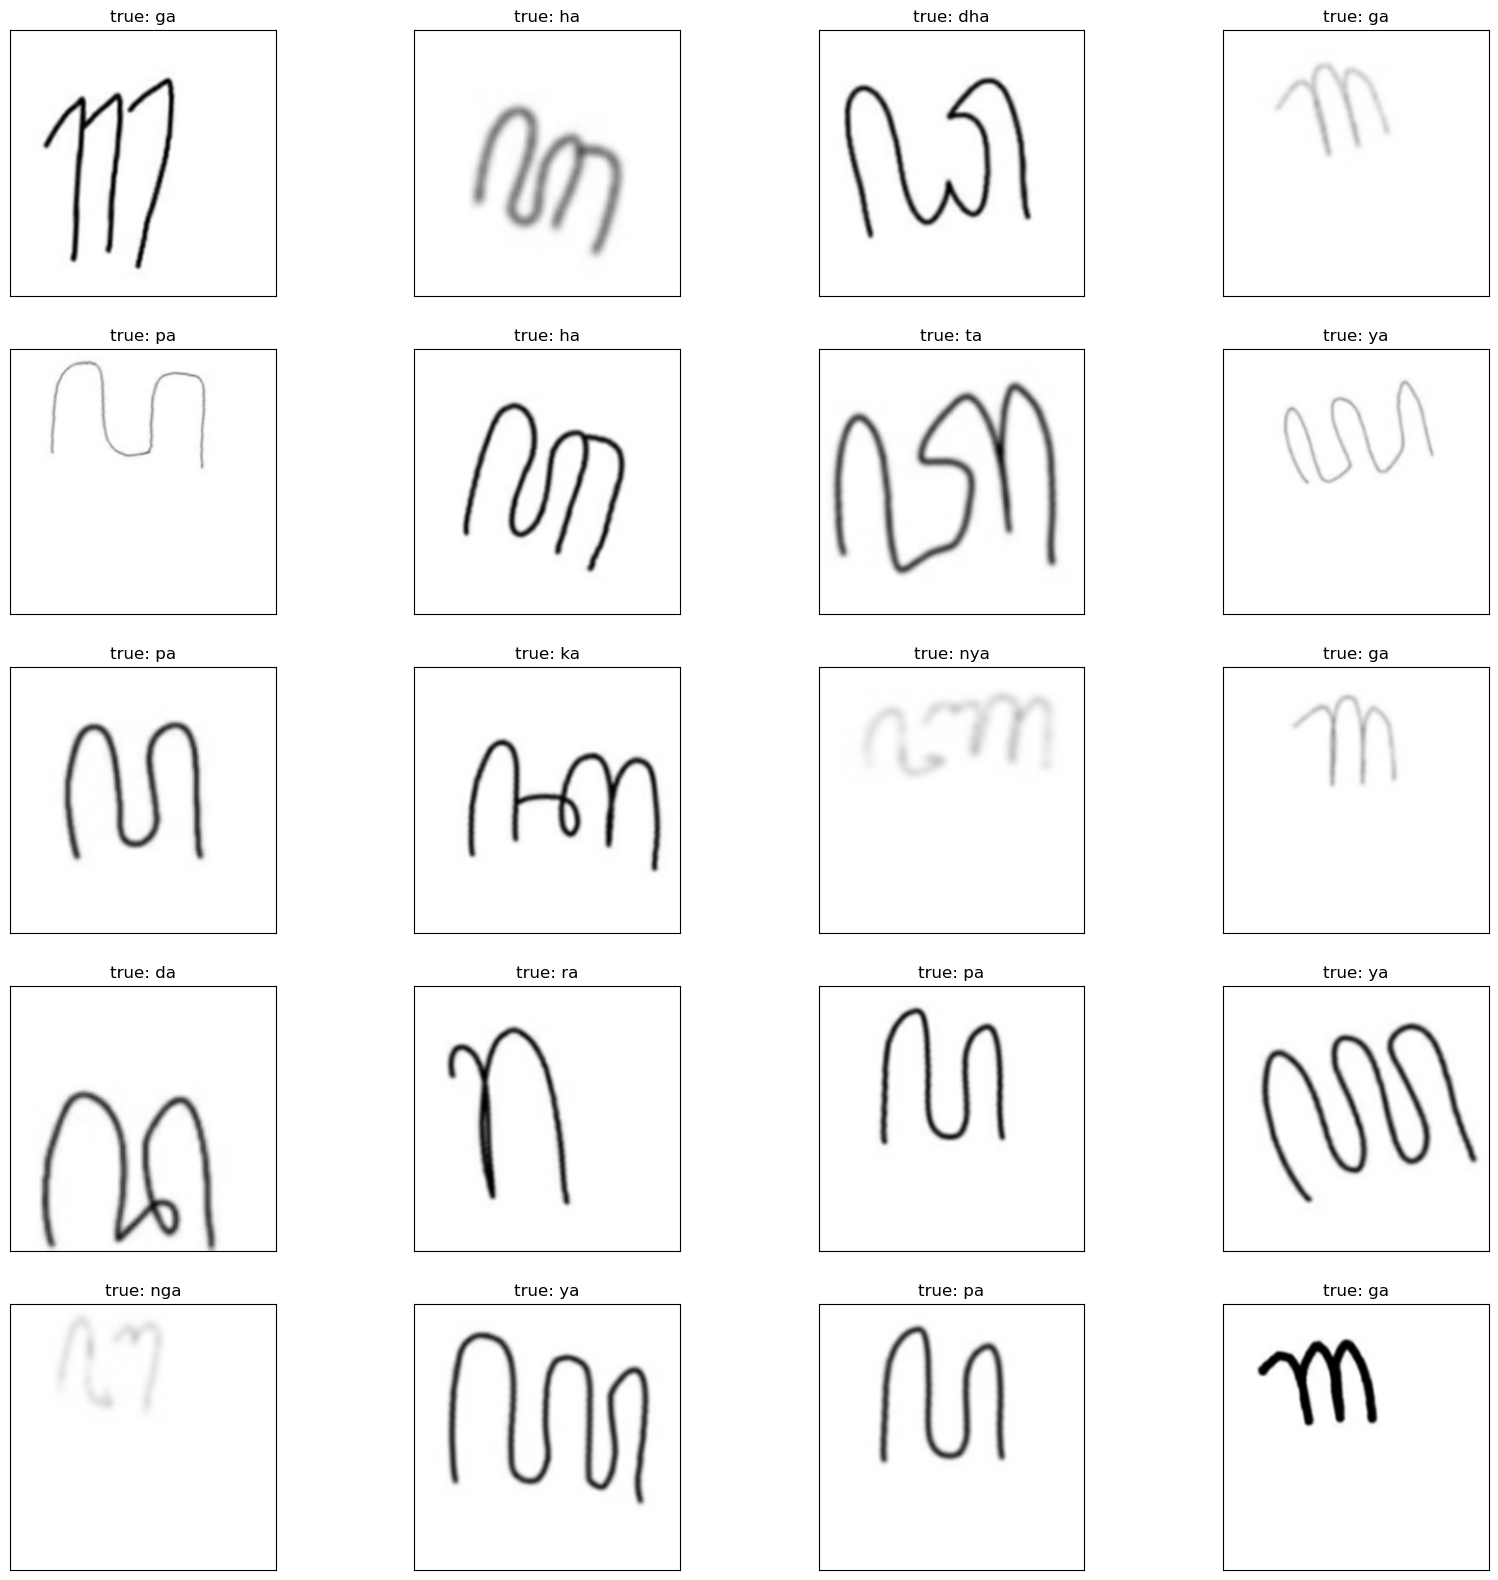

In [22]:
plot_images(train_ds)

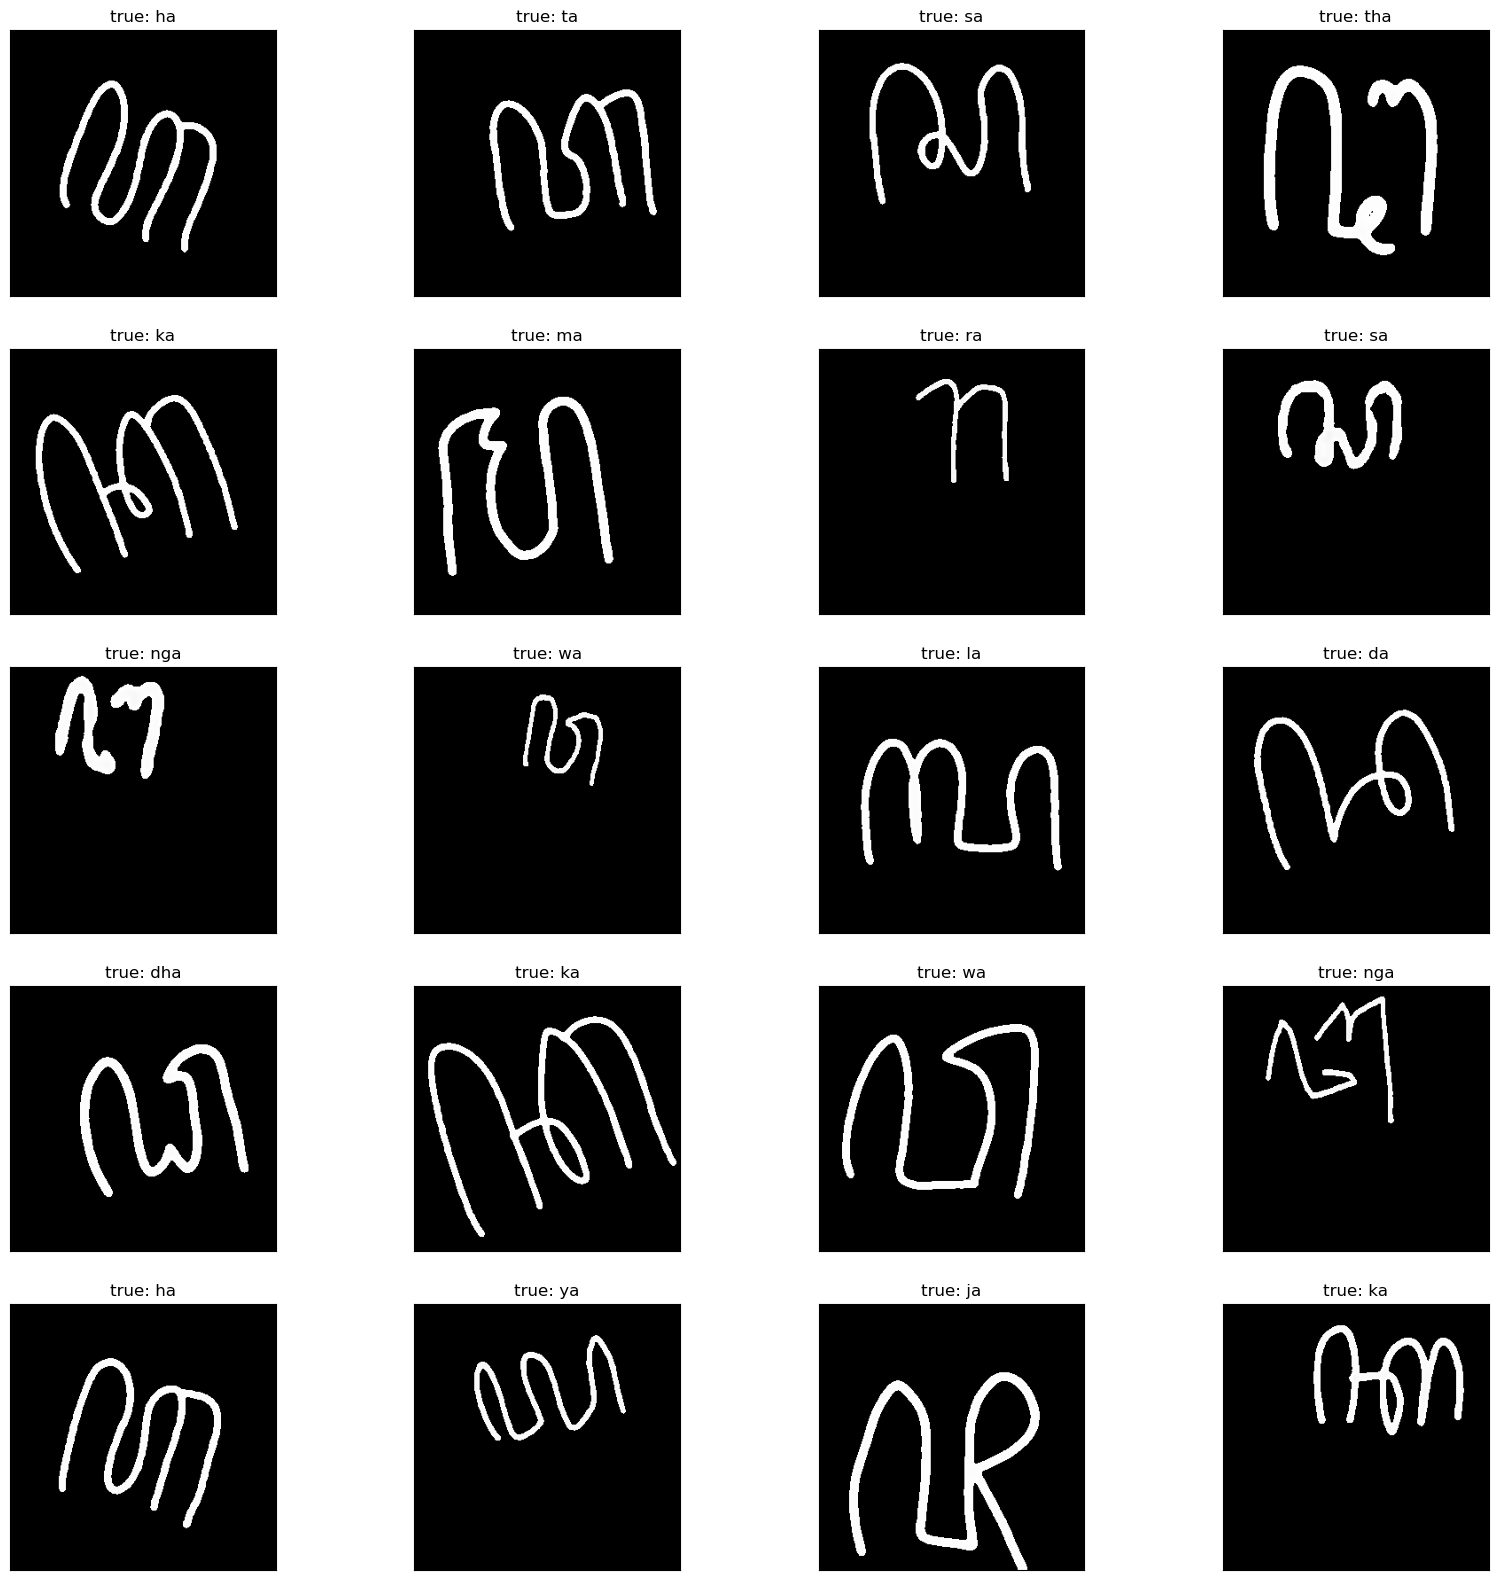

In [23]:
plot_images(train_ds_mapped)

# Model Building

In [24]:
# Download vgg

vgg_no_train = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)
vgg_no_train.trainable = False

vgg_half_train = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)
vgg_half_train.trainable = True

vgg_full_train = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)
vgg_full_train.trainable = True

58889256/58889256 [==============================] - 0s 0us/step


In [25]:
# half freeze
num_layers = len(vgg_half_train.layers) // 2
num_layers
for i in range(num_layers):
    vgg_half_train.layers[i].trainable = False

# Model Summary

In [26]:
# full freeze
name = 'aksara_jawa_vgg_full_freeze_v1'

vgg_transferred_full = Sequential([
    vgg_no_train,
    GlobalAveragePooling2D(),
    
    # 1 layer
    Dropout(0.5),
    
    Dense(1024, activation='relu'),
    # 2 layer
    Dropout(0.25),
    
    Dense(n_classes, activation='softmax')
], name=name)

vgg_transferred_full.compile(
    loss=LOSS,
    optimizer=SGD(learning_rate=LEARNING_RATE),
#     optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS
)

vgg_transferred_full.summary()
print('\n\n\n', '*'*90)


# half
name = 'aksara_jawa_vgg_half_freeze_v1'

vgg_transferred_half = Sequential([
    vgg_half_train,
    GlobalAveragePooling2D(),
    
    # 1 layer
    Dropout(0.5),
    
    Dense(1024, activation='relu'),    
    # 2 layer
    Dropout(0.25),
    
    Dense(n_classes, activation='softmax')
], name=name)

vgg_transferred_half.compile(
    loss=LOSS,
    optimizer=SGD(learning_rate=LEARNING_RATE),
#     optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS
)

vgg_transferred_half.summary()
print('\n\n\n', '*'*90)


# no freeze
name = 'aksara_jawa_vgg_no_freeze_v1'

vgg_transferred_no = Sequential([
    vgg_full_train,
    GlobalAveragePooling2D(),
    
    # 1 layer
    Dropout(0.5),
    
    Dense(1024, activation='relu'),
    # 2 layer
    Dropout(0.25),
    
    Dense(n_classes, activation='softmax')
], name=name)

vgg_transferred_no.compile(
    loss=LOSS,
    optimizer=SGD(learning_rate=LEARNING_RATE),
#     optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS
)

vgg_transferred_no.summary()

Model: "aksara_jawa_vgg_full_freeze_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 9, 9, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 20)                20500     
                                    

# Train Full Freeze

In [27]:
print(f"\nTraining {vgg_transferred_full.name}: ")

csv_file = f'{vgg_transferred_full.name}.csv'

time = timer(None)
history_full = vgg_transferred_full.fit(
    train_ds_mapped, 
    validation_data=val_ds_mapped, 
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(patience=EARLYSTOP_PATIENCE, restore_best_weights=True),
        ModelCheckpoint(f"checkpoint-{vgg_transferred_full.name}.h5", save_best_only=True),
        CSVLogger(csv_file)
    ],
    batch_size=BATCH_SIZE,
)
time_taken = timer(time)
print(time_taken)


Training aksara_jawa_vgg_full_freeze_v1: 
Epoch 1/50
532/532 [==============================] - 94s 157ms/step - loss: 3.1196 - accuracy: 0.0479 - val_loss: 3.0036 - val_accuracy: 0.0261
Epoch 2/50
532/532 [==============================] - 75s 141ms/step - loss: 3.0752 - accuracy: 0.0539 - val_loss: 2.9923 - val_accuracy: 0.0367
Epoch 3/50
532/532 [==============================] - 75s 141ms/step - loss: 3.0676 - accuracy: 0.0498 - val_loss: 2.9886 - val_accuracy: 0.0406
Epoch 4/50
532/532 [==============================] - 76s 143ms/step - loss: 3.0625 - accuracy: 0.0525 - val_loss: 2.9863 - val_accuracy: 0.0512
Epoch 5/50
532/532 [==============================] - 75s 141ms/step - loss: 3.0597 - accuracy: 0.0534 - val_loss: 2.9849 - val_accuracy: 0.0531
Epoch 6/50
532/532 [==============================] - 76s 143ms/step - loss: 3.0542 - accuracy: 0.0514 - val_loss: 2.9833 - val_accuracy: 0.0638
Epoch 7/50
532/532 [==============================] - 76s 143ms/step - loss: 3.0538 - a

# Train Half Freeze

In [28]:
print(f"\nTraining {vgg_transferred_half.name}: ")

csv_file = f'{vgg_transferred_half.name}.csv'

time = timer(None)
history_half = vgg_transferred_half.fit(
    train_ds_mapped, 
    validation_data=val_ds_mapped, 
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(patience=EARLYSTOP_PATIENCE, restore_best_weights=True),
        ModelCheckpoint(f"checkpoint-{vgg_transferred_half.name}.h5", save_best_only=True),
        CSVLogger(csv_file)
    ],
    batch_size=BATCH_SIZE,
)
time_taken = timer(time)
print(time_taken)


Training aksara_jawa_vgg_half_freeze_v1: 
Epoch 1/50
532/532 [==============================] - 126s 228ms/step - loss: 3.1125 - accuracy: 0.0469 - val_loss: 2.9889 - val_accuracy: 0.0541
Epoch 2/50
532/532 [==============================] - 120s 225ms/step - loss: 3.0448 - accuracy: 0.0538 - val_loss: 2.9735 - val_accuracy: 0.1150
Epoch 3/50
532/532 [==============================] - 119s 223ms/step - loss: 3.0157 - accuracy: 0.0612 - val_loss: 2.9632 - val_accuracy: 0.1034
Epoch 4/50
532/532 [==============================] - 120s 225ms/step - loss: 3.0057 - accuracy: 0.0628 - val_loss: 2.9519 - val_accuracy: 0.1198
Epoch 5/50
532/532 [==============================] - 120s 224ms/step - loss: 2.9976 - accuracy: 0.0620 - val_loss: 2.9387 - val_accuracy: 0.1469
Epoch 6/50
532/532 [==============================] - 120s 224ms/step - loss: 2.9711 - accuracy: 0.0784 - val_loss: 2.9206 - val_accuracy: 0.1691
Epoch 7/50
532/532 [==============================] - 120s 225ms/step - loss: 2.9

# Train No Freeze

In [29]:
print(f"\nTraining {vgg_transferred_no.name}: ")

csv_file = f'{vgg_transferred_no.name}.csv'

time = timer(None)
history_no = vgg_transferred_no.fit(
    train_ds_mapped, 
    validation_data=val_ds_mapped, 
    epochs=EPOCHS,
    callbacks=[
        EarlyStopping(patience=EARLYSTOP_PATIENCE, restore_best_weights=True),
        ModelCheckpoint(f"checkpoint-{vgg_transferred_no.name}.h5", save_best_only=True),
        CSVLogger(csv_file)
    ],
    batch_size=BATCH_SIZE,
)
time_taken = timer(time)
print(time_taken)


Training aksara_jawa_vgg_no_freeze_v1: 
Epoch 1/50
532/532 [==============================] - 217s 397ms/step - loss: 3.1531 - accuracy: 0.0504 - val_loss: 3.0106 - val_accuracy: 0.0425
Epoch 2/50
532/532 [==============================] - 207s 388ms/step - loss: 3.0547 - accuracy: 0.0543 - val_loss: 2.9926 - val_accuracy: 0.0444
Epoch 3/50
532/532 [==============================] - 207s 388ms/step - loss: 3.0277 - accuracy: 0.0553 - val_loss: 2.9848 - val_accuracy: 0.0715
Epoch 4/50
532/532 [==============================] - 208s 390ms/step - loss: 3.0127 - accuracy: 0.0554 - val_loss: 2.9767 - val_accuracy: 0.0821
Epoch 5/50
532/532 [==============================] - 208s 390ms/step - loss: 2.9958 - accuracy: 0.0624 - val_loss: 2.9663 - val_accuracy: 0.1034
Epoch 6/50
532/532 [==============================] - 207s 389ms/step - loss: 2.9821 - accuracy: 0.0647 - val_loss: 2.9544 - val_accuracy: 0.1411
Epoch 7/50
532/532 [==============================] - 208s 390ms/step - loss: 2.966

# Evaluate

In [30]:
print('\nfull freeze')
test_loss_f, test_acc_f = vgg_transferred_full.evaluate(test_ds_mapped)
print("Loss    : {:.4}".format(test_loss_f))
print("Accuracy: {:.4}%".format(test_acc_f*100))

print('\nhalf freeze')
test_loss_h, test_acc_h = vgg_transferred_half.evaluate(test_ds_mapped)
print("Loss    : {:.4}".format(test_loss_h))
print("Accuracy: {:.4}%".format(test_acc_h*100))

print('\nno freeze')
test_loss_n, test_acc_n = vgg_transferred_no.evaluate(test_ds_mapped)
print("Loss    : {:.4}".format(test_loss_n))
print("Accuracy: {:.4}%".format(test_acc_n*100))


full freeze
32/32 [==============================] - 7s 208ms/step - loss: 2.9154 - accuracy: 0.2337
Loss    : 2.915
Accuracy: 23.37%

half freeze
32/32 [==============================] - 4s 126ms/step - loss: 0.0802 - accuracy: 0.9762
Loss    : 0.08022
Accuracy: 97.62%

no freeze
32/32 [==============================] - 4s 127ms/step - loss: 0.0498 - accuracy: 0.9881
Loss    : 0.04981
Accuracy: 98.81%


# Graph

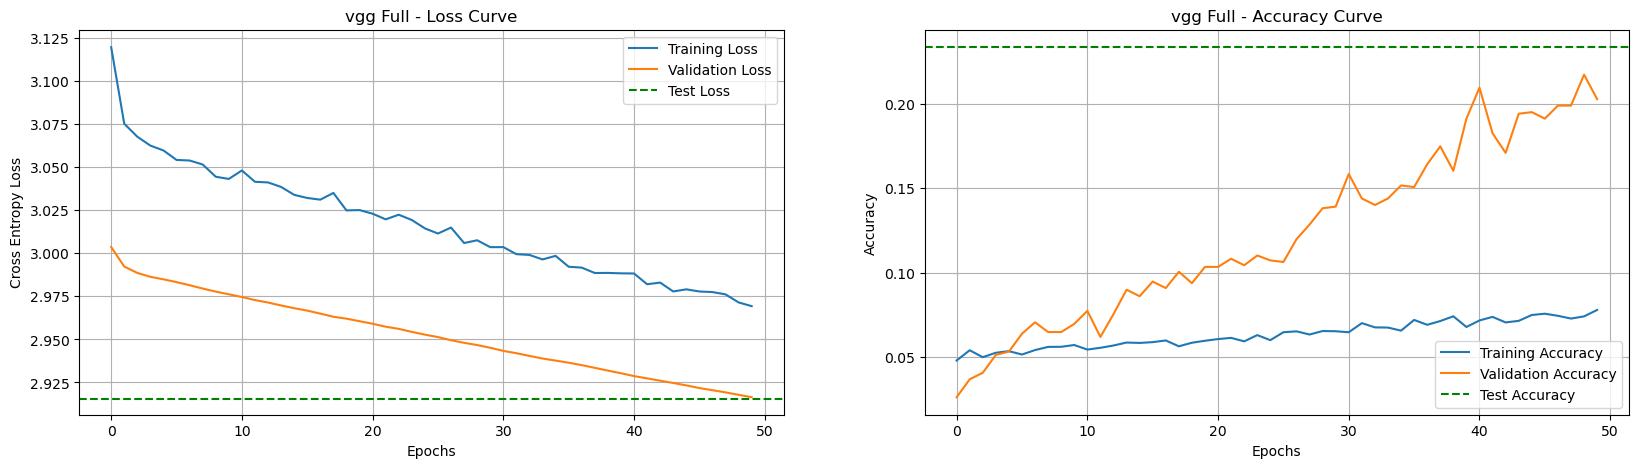

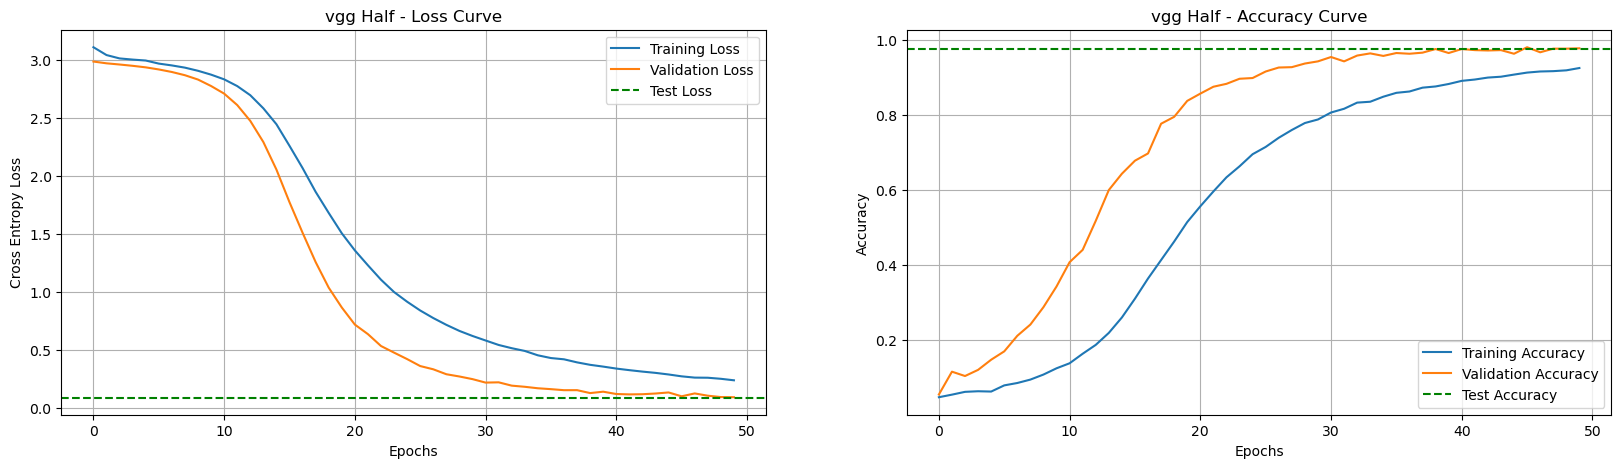

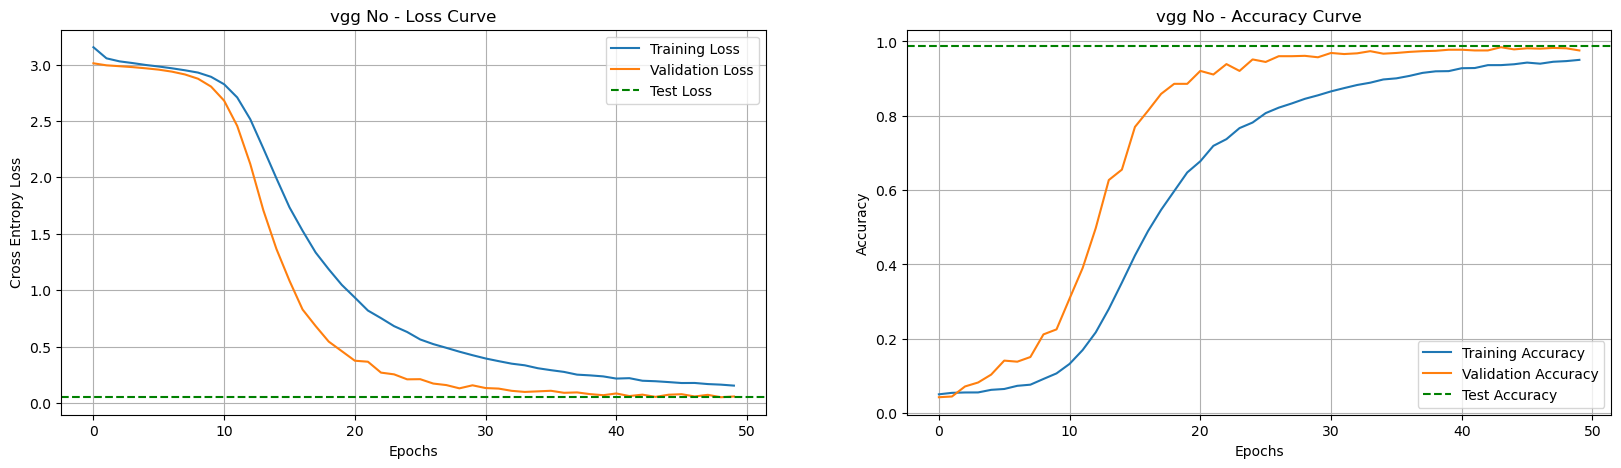

In [31]:
plot_history(history_full, test_loss_f, test_acc_f, 'vgg Full')
plot_history(history_half, test_loss_h, test_acc_h, 'vgg Half')
plot_history(history_no, test_loss_n, test_acc_n, 'vgg No')

# Confusion Matrix

In [32]:
y_f, y_h, y_n, = [], [], []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds_mapped:   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds_f = vgg_transferred_full.predict(image_batch, verbose=0)
    preds_h = vgg_transferred_half.predict(image_batch, verbose=0)
    preds_n = vgg_transferred_no.predict(image_batch, verbose=0)
    # append predicted labels
    y_f.append(np.argmax(preds_f, axis = - 1))
    y_h.append(np.argmax(preds_h, axis = - 1))
    y_n.append(np.argmax(preds_n, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels_f = tf.concat([item for item in y_f], axis = 0)
predicted_labels_h = tf.concat([item for item in y_h], axis = 0)
predicted_labels_n = tf.concat([item for item in y_n], axis = 0)

cls()


full freeze


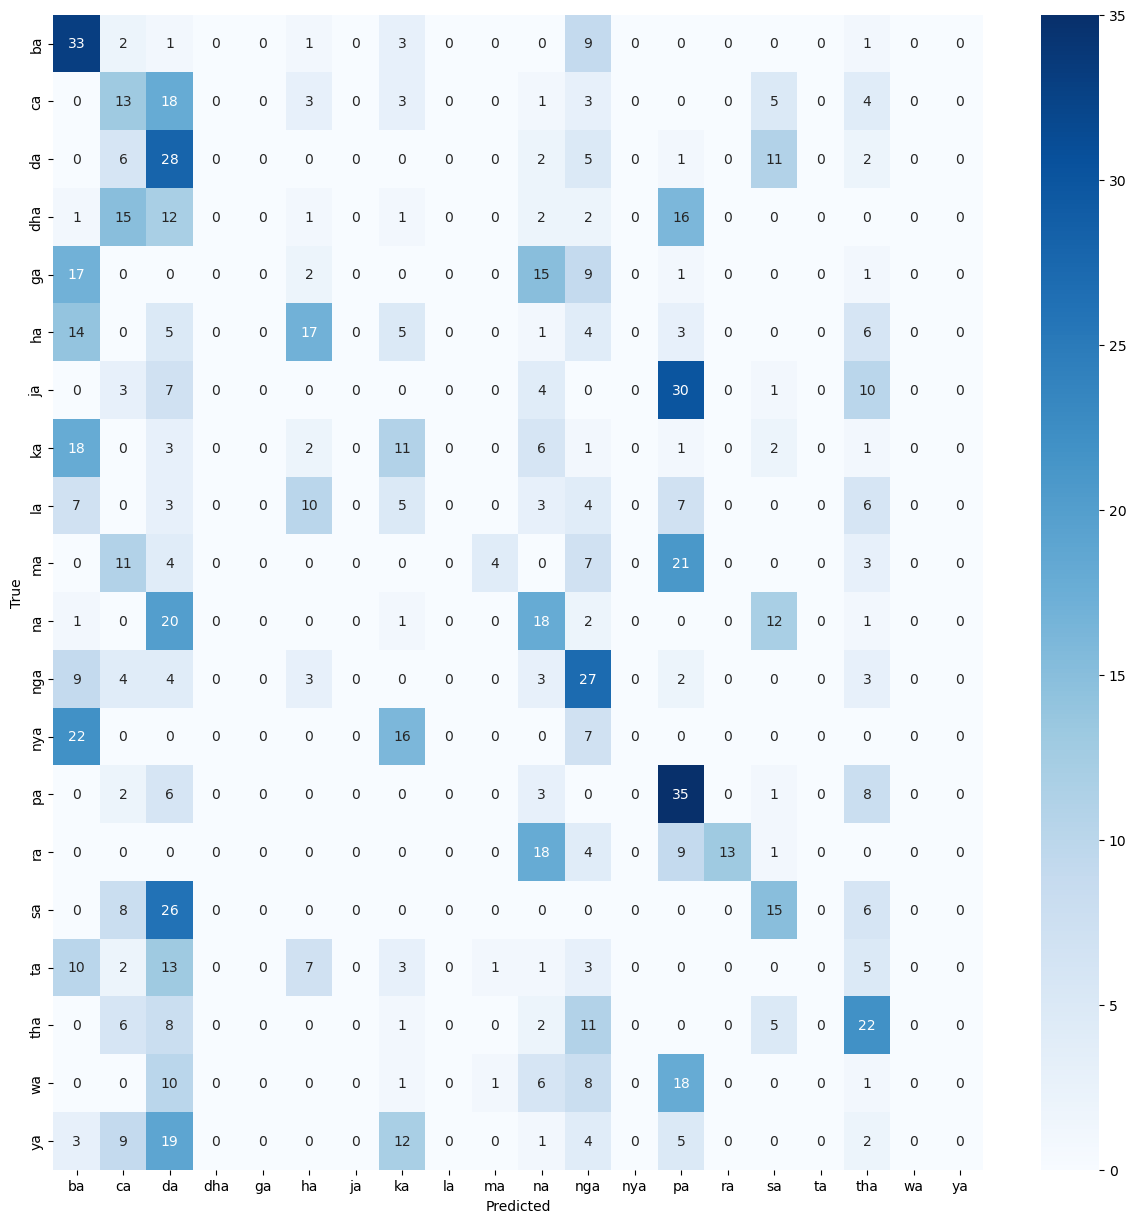


half freeze


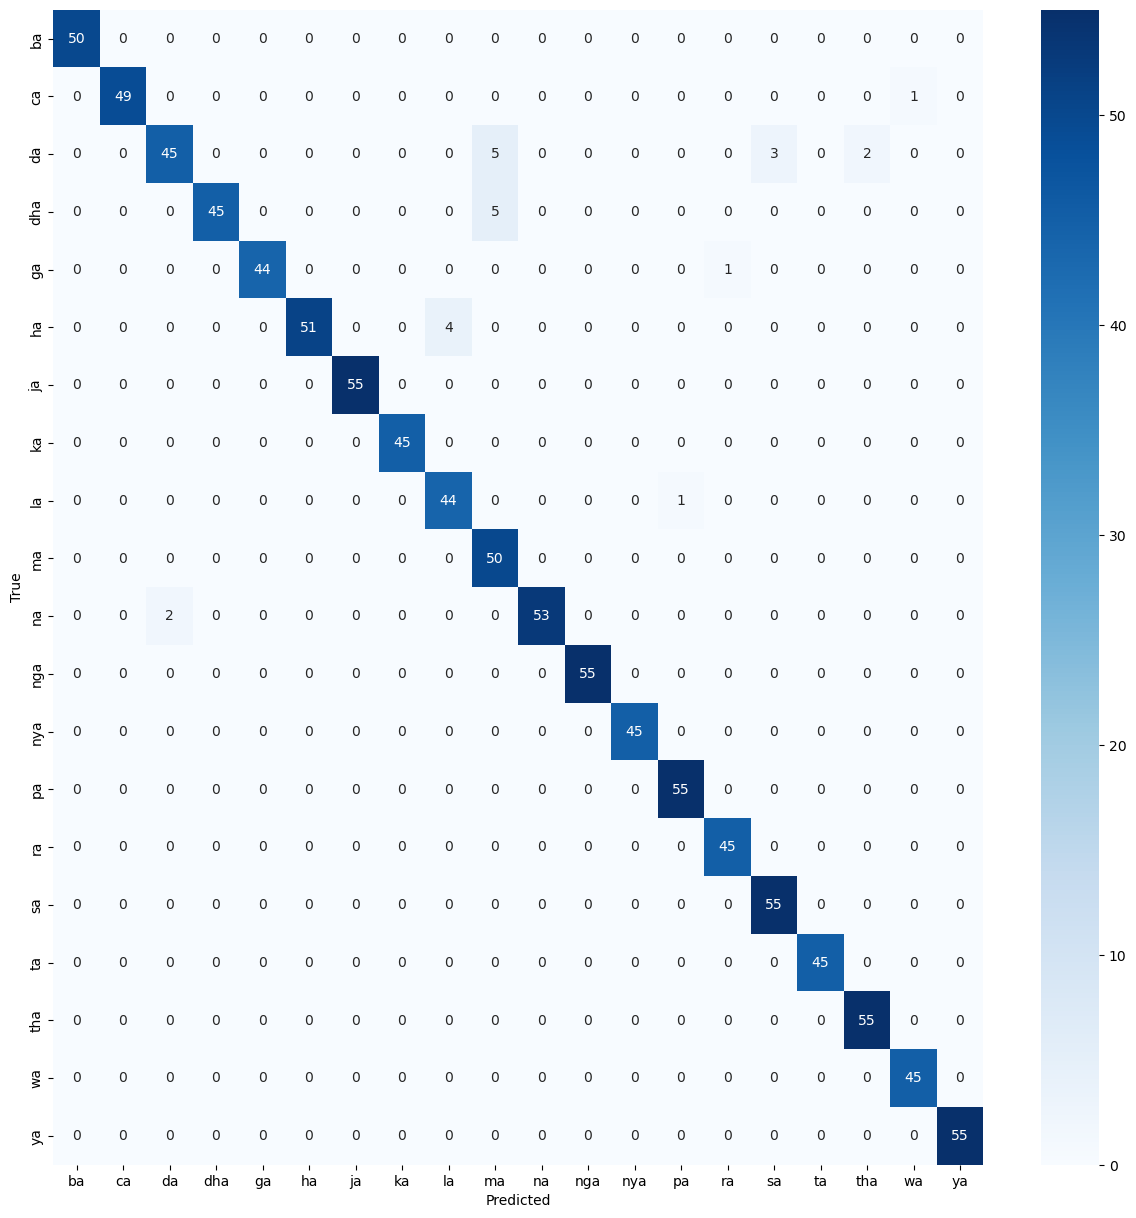


no freeze


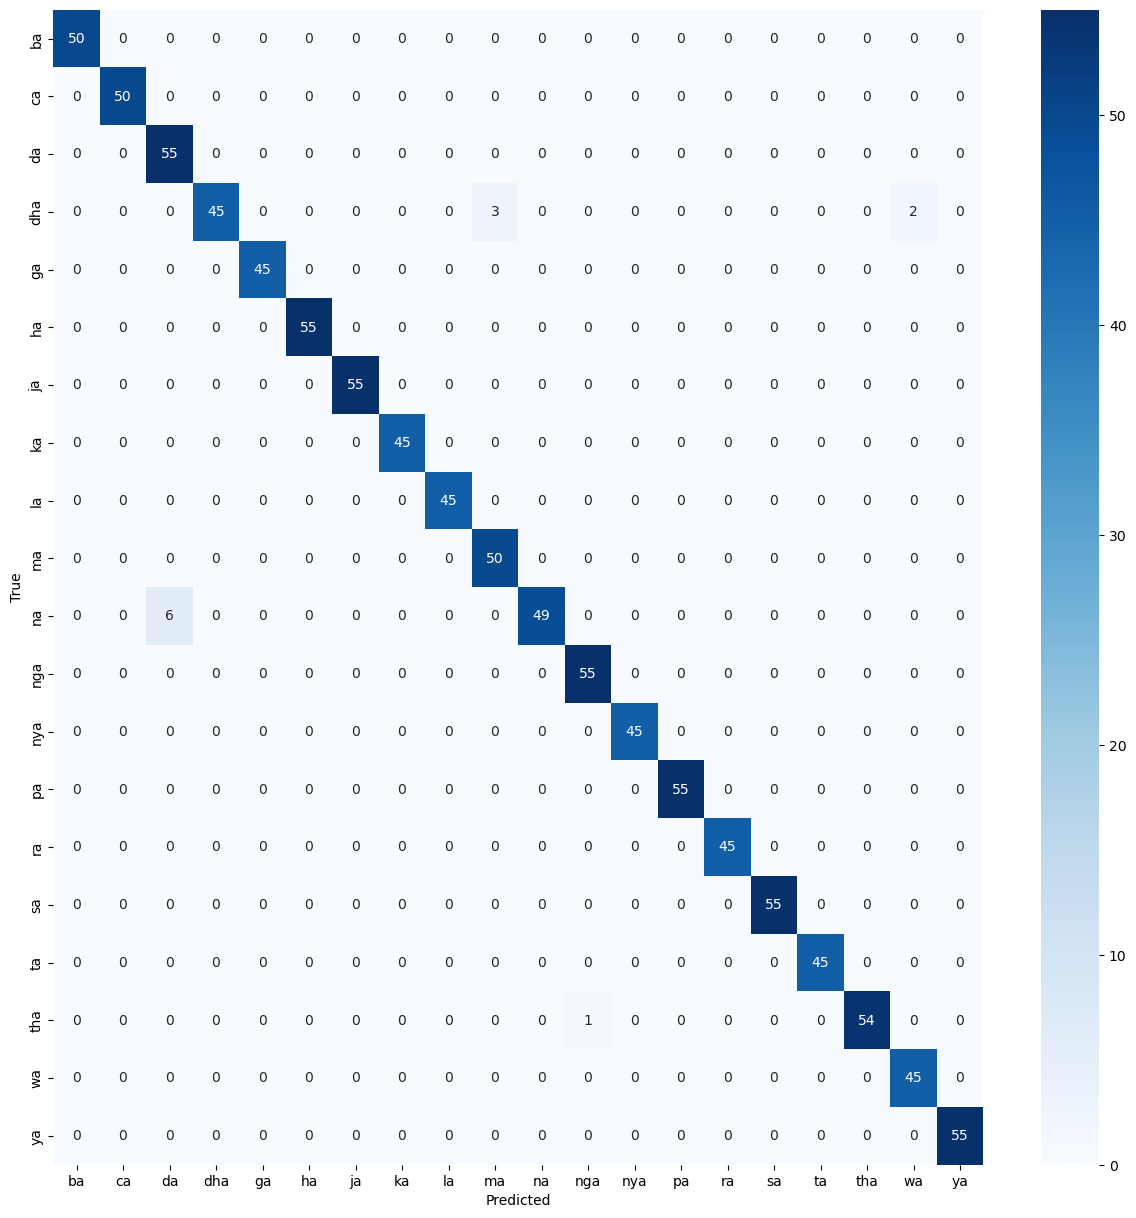

In [33]:
print('\nfull freeze')
plot_confusion_m(correct_labels, predicted_labels_f, class_names)

print('\nhalf freeze')
plot_confusion_m(correct_labels, predicted_labels_h, class_names)

print('\nno freeze')
plot_confusion_m(correct_labels, predicted_labels_n, class_names)

# Prediction Visualization

1/1 [==============================] - 0s 18ms/step


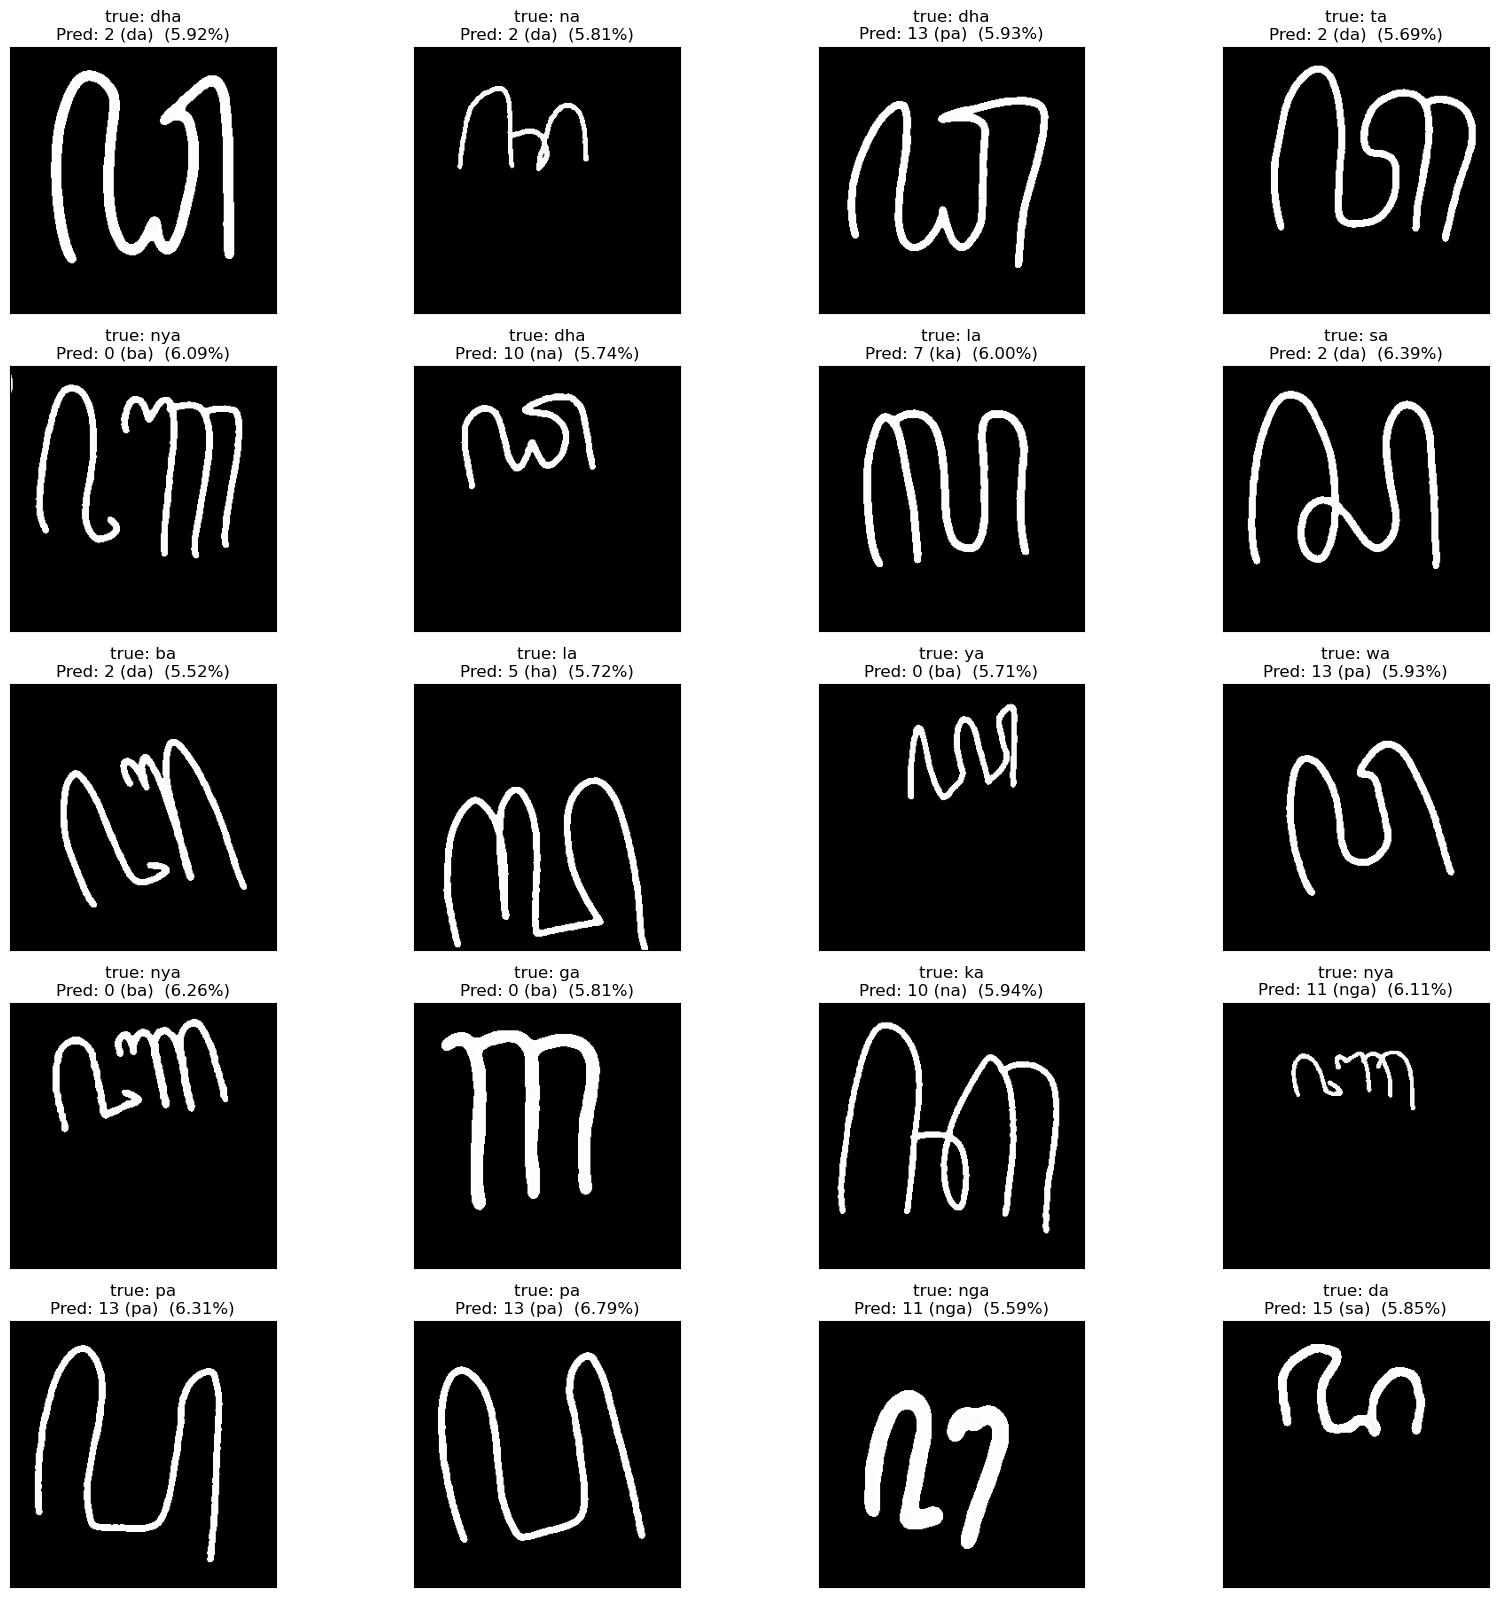

In [34]:
plot_images(test_ds_mapped, model=vgg_transferred_full, n_rows=5)

1/1 [==============================] - 0s 21ms/step


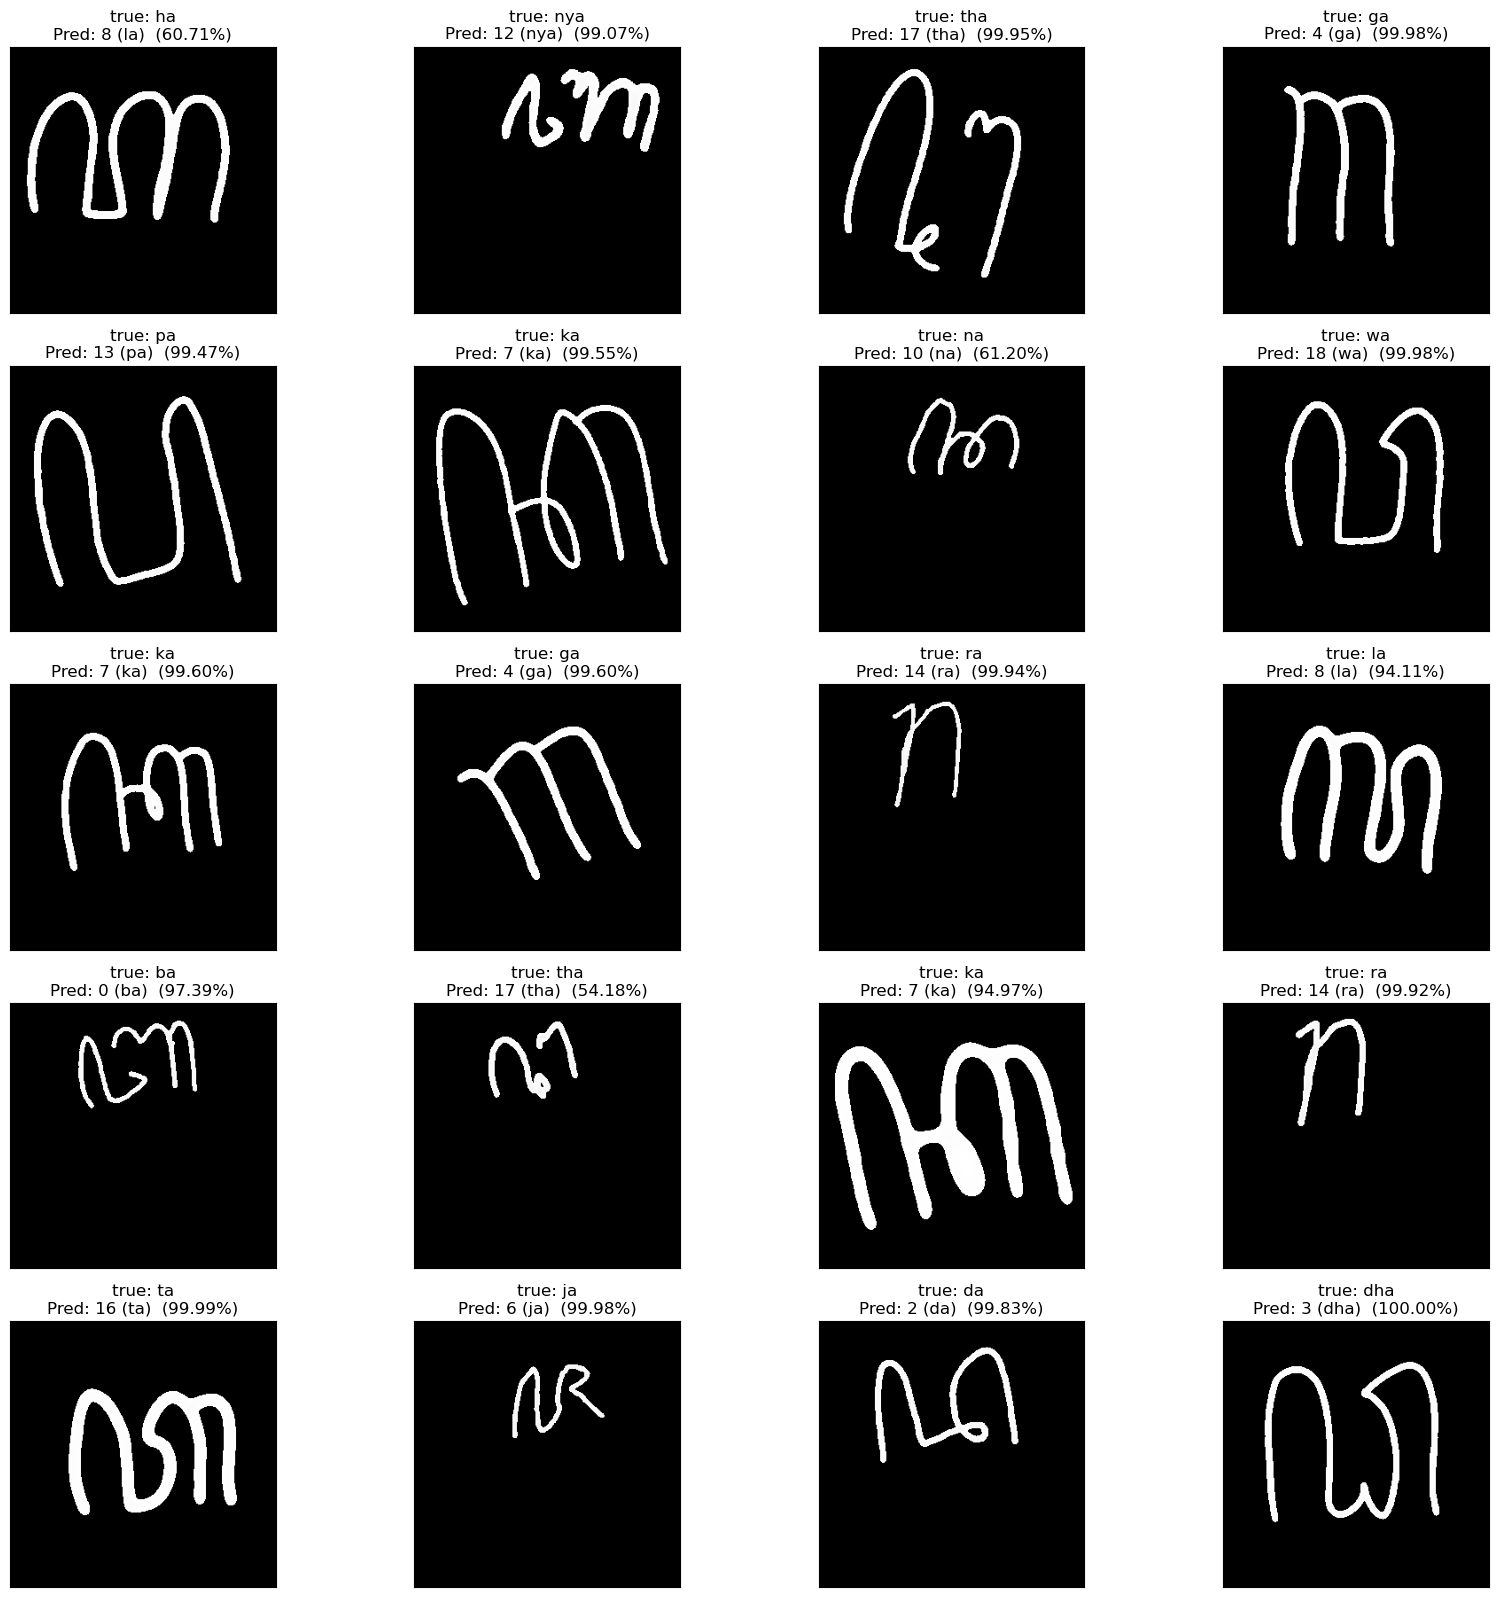

In [35]:
plot_images(test_ds_mapped, model=vgg_transferred_half, n_rows=5)

1/1 [==============================] - 0s 28ms/step


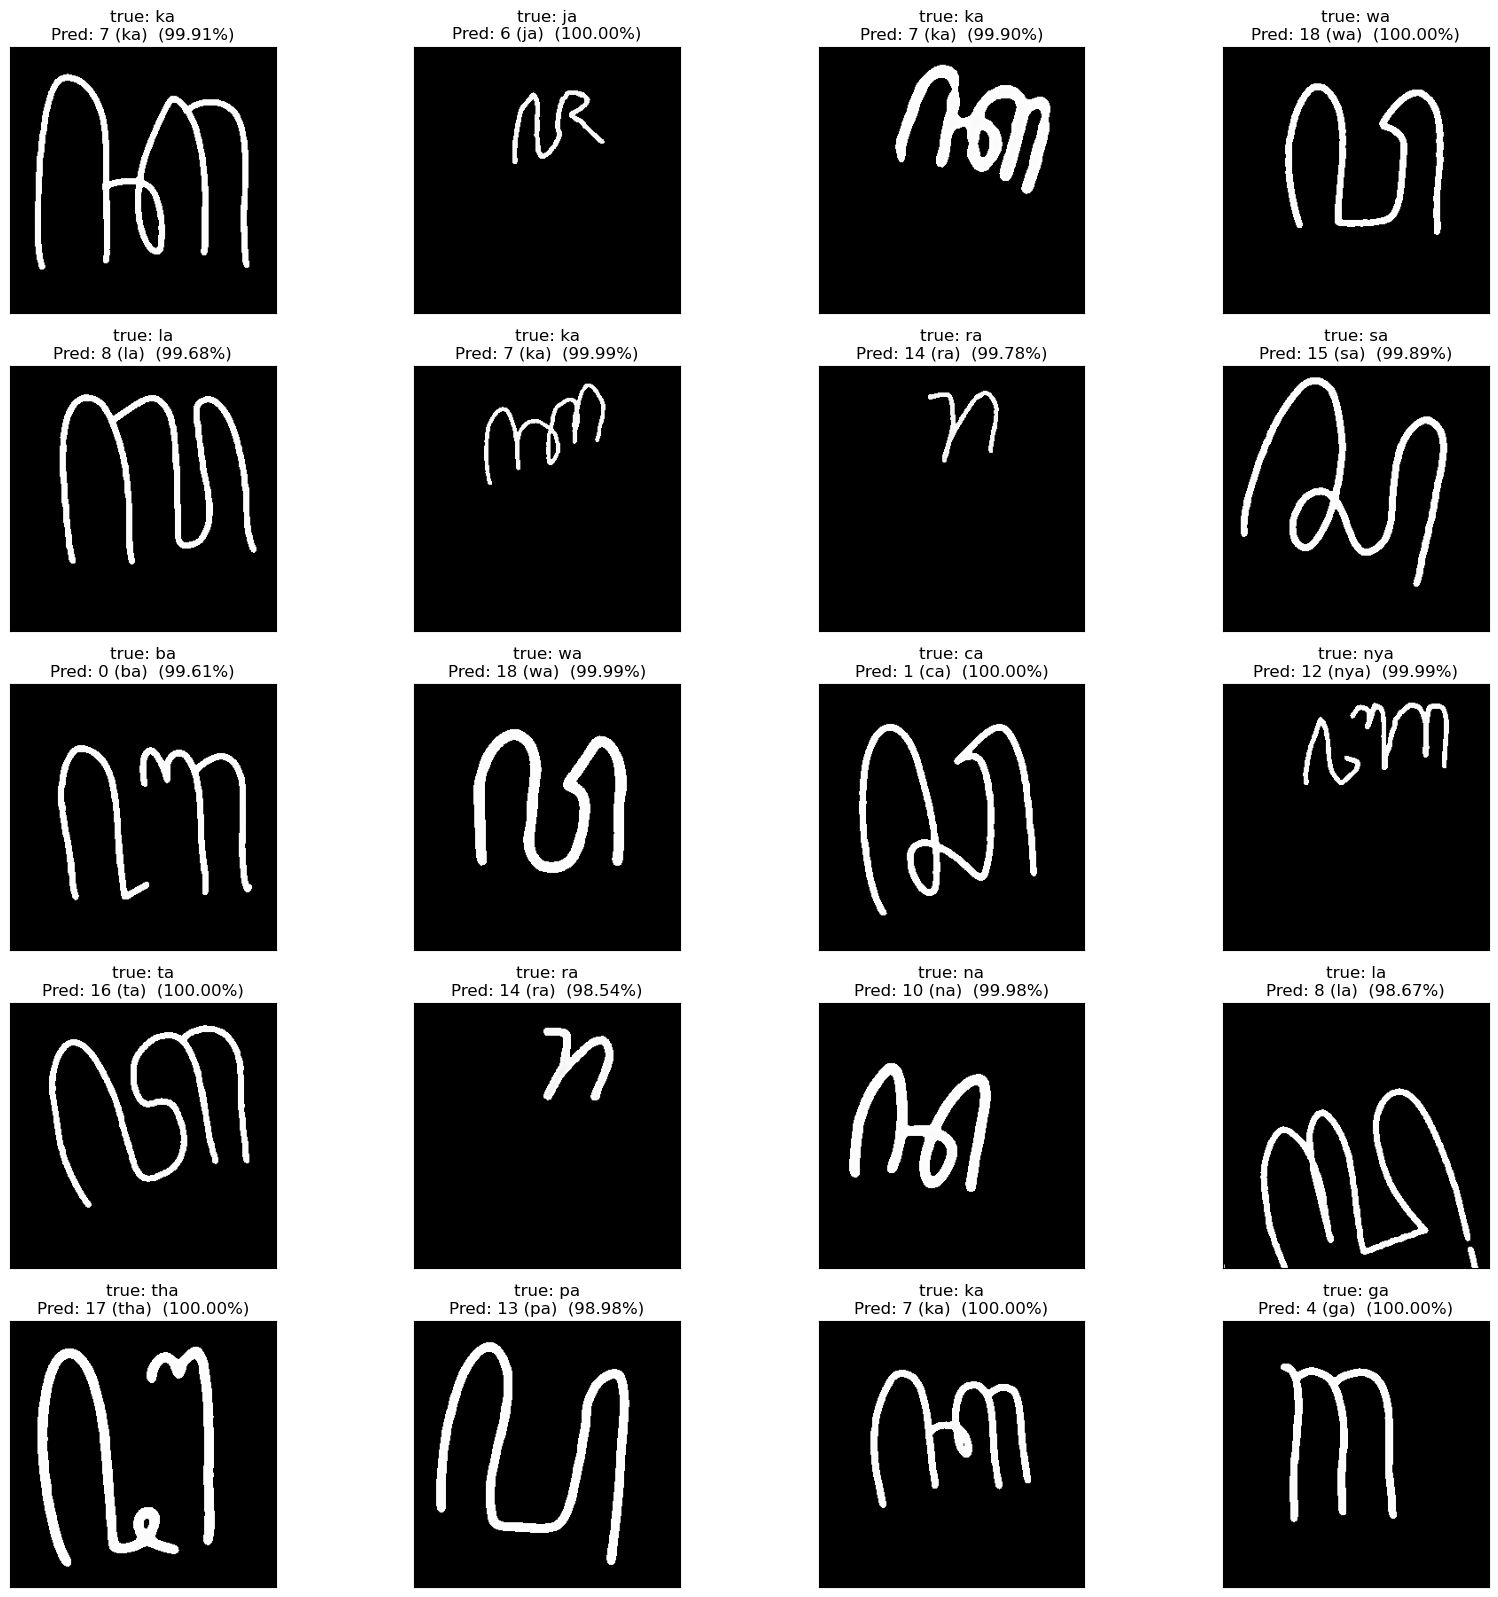

In [36]:
plot_images(test_ds_mapped, model=vgg_transferred_no, n_rows=5)

# CSV Preview

In [37]:
pd.read_csv(f'{vgg_transferred_full.name}.csv').head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.047885,3.119599,0.026087,3.003632
1,1,0.053937,3.075204,0.036715,2.992292
2,2,0.049824,3.067644,0.040580,2.988593
3,3,0.052468,3.062496,0.051208,2.986333
4,4,0.053408,3.059672,0.053140,2.984878


In [38]:
pd.read_csv(f'{vgg_transferred_half.name}.csv').head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.046886,3.112498,0.054106,2.988852
1,1,0.053760,3.044845,0.114976,2.973461
2,2,0.061222,3.015745,0.103382,2.963229
3,3,0.062808,3.005685,0.119807,2.951910
4,4,0.061986,2.997584,0.146860,2.938658


In [39]:
pd.read_csv(f'{vgg_transferred_no.name}.csv').head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.050353,3.153096,0.042512,3.010602
1,1,0.054289,3.054666,0.044444,2.992637
2,2,0.055288,3.027746,0.071498,2.984777
3,3,0.055405,3.012690,0.082126,2.976710
4,4,0.062397,2.995838,0.103382,2.966310


# Save Model

In [40]:
vgg_transferred_full.save(vgg_transferred_full.name+'.h5')
vgg_transferred_half.save(vgg_transferred_half.name+'.h5')
vgg_transferred_no.save(vgg_transferred_no.name+'.h5')